**TRAINING RANDOM FOREST MODEL ON THE NEWLY CREATED DATA**

In [32]:
import duckdb
con = duckdb.connect('../sql_databases/skyhack.duckdb')
con.execute("SHOW TABLES").df()

,name
0,PNRFlight
1,airports_cleaned
2,bagsData_cleaned
3,flight_difficulty_ml
4,flights_cleaned
5,pnr_remarks_cleaned


In [33]:
#load the data
# load the labeled data
df = con.execute("""
    SELECT pax_load_factor, ssr_total, minimum_turn_minutes, carrier, transfer_to_checked_ratio, difficulty_class
    FROM flight_difficulty_ml
    WHERE pax_load_factor IS NOT NULL AND minimum_turn_minutes > 0
""").df()

df.head()

,pax_load_factor,ssr_total,minimum_turn_minutes,carrier,transfer_to_checked_ratio,difficulty_class
0,0.687151,2,56,MAINLINE,2.000000,Easy
1,1.047619,2,43,MAINLINE,0.793103,Difficult
2,0.980000,1,29,EXPRESS,8.500000,Difficult
3,1.110000,7,62,MAINLINE,1.975000,Medium
4,1.000000,1,29,EXPRESS,12.000000,Easy


In [34]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# define features (X) and target (y)
X = df[['pax_load_factor', 'ssr_total', 'minimum_turn_minutes', 'carrier', 'transfer_to_checked_ratio']]
y = df['difficulty_class']

# split 80/20 for training/testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# define column types
num_features = ['pax_load_factor', 'ssr_total', 'minimum_turn_minutes', 'transfer_to_checked_ratio']
cat_features = ['carrier']

# preprocessing: scale numeric + one-hot encode categorical
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
    ])


In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'classifier__n_estimators': [200, 400, 600],
    'classifier__max_depth': [8, 12, 16, None],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__max_features': ['sqrt', 'log2']
}

grid_search = GridSearchCV(clf, param_grid, cv=3, scoring='f1_macro', verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)

Fitting 3 folds for each of 72 candidates, totalling 216 fits
{'classifier__max_depth': 8, 'classifier__max_features': 'sqrt', 'classifier__min_samples_split': 10, 'classifier__n_estimators': 600}


In [ ]:
from sklearn.ensemble import RandomForestClassifier

best_params = {
    'n_estimators': 600,
    'max_depth': 8,
    'max_features': 'sqrt',
    'min_samples_split': 10
}



final_clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        n_estimators=best_params['n_estimators'],
        max_depth=best_params['max_depth'],
        max_features=best_params['max_features'],
        min_samples_split=best_params['min_samples_split'],
        random_state=42,
        class_weight='balanced'
    ))
])

# fit
final_clf.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [ ]:
y_pred = clf.predict(X_test)

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:\n")
print(confusion_matrix(y_test, y_pred))



Classification Report:

              precision    recall  f1-score   support

   Difficult       0.41      0.40      0.40       540
        Easy       0.41      0.38      0.39       552
      Medium       0.37      0.40      0.38       521

    accuracy                           0.39      1613
   macro avg       0.40      0.39      0.39      1613
weighted avg       0.40      0.39      0.39      1613


Confusion Matrix:

[[217 156 167]
 [149 209 194]
 [167 144 210]]


In [ ]:
import numpy as np

rf_model = clf.named_steps['classifier']
feature_names = num_features + list(
    clf.named_steps['preprocessor']
    .named_transformers_['cat']
    .get_feature_names_out(cat_features)
)

importances = rf_model.feature_importances_
sorted_idx = np.argsort(importances)[::-1]

print("\nFeature Importance:")
for i in sorted_idx:
    print(f"{feature_names[i]:35s}: {importances[i]:.3f}")



Feature Importance:
transfer_to_checked_ratio          : 0.332
pax_load_factor                    : 0.289
minimum_turn_minutes               : 0.207
ssr_total                          : 0.122
carrier_EXPRESS                    : 0.029
carrier_MAINLINE                   : 0.021


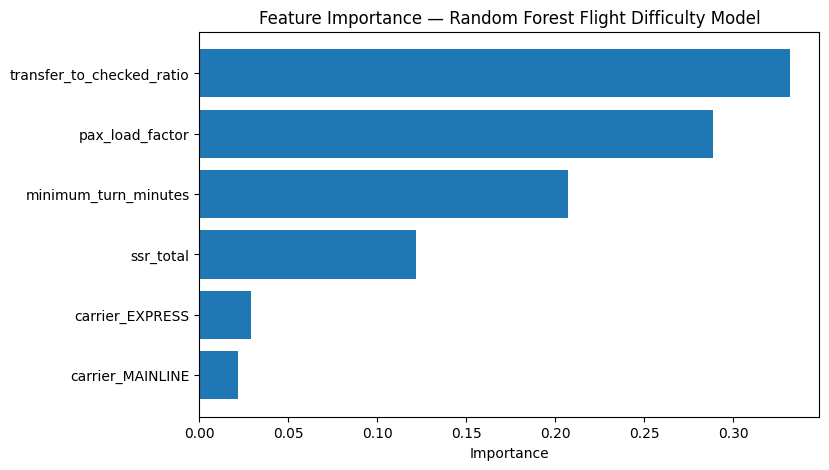

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.barh([feature_names[i] for i in sorted_idx], importances[sorted_idx])
plt.xlabel('Importance')
plt.title('Feature Importance — Random Forest Flight Difficulty Model')
plt.gca().invert_yaxis()
plt.show()

In [38]:
df['predicted_difficulty'] = clf.predict(df[X.columns])
df['difficulty_score'] = clf.predict_proba(df[X.columns])[:, list(clf.classes_).index('Difficult')]
df.to_csv('new_data.csv', index=False)


In [39]:
con.close()